<h1><center>IST 707: Data Analytics</center>
<center>Extra Credit Assignment: House Prices-Advanced Regression Problem</center></h1>

<h2><left>Name: Tanishk Parihar</left>
<br><left>Date of Submission: 05/08/2020</left></h2>

**Problem Statement: With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, the competition challenges to predict the final price of each home. This is a regression problem as we are using the independent variables to predict house prices which is a continuous variable.
<br>
<br>
Reason to choose this topic: As the assignments that we have done during the semester were based on classification, working on this assignment has given me the chance to work on a regression problem. In addition, the high dimensionality of the dataset gives me a chance to experience the process of feature selection by dropping some variables.**

Link to the dataset: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [191]:
#importing all required libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor
from collections import OrderedDict
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error,make_scorer

In [192]:
pd.set_option("display.max_columns",80)

In [193]:
data=pd.read_csv("train.csv")

In [194]:
# drop the IDs as they are all unique
data.drop("Id",inplace=True,axis=1)

In [195]:
# Filling the columns having more than 50% missing values with "No" after referring to the description of the data
for i in data.columns:
    if (data[i].isnull().sum()>(len(data)/2)):
        data[i].fillna("No",inplace=True)

**Below, we plot two different plots which show us outlier so we drop them as they will skew our data.**

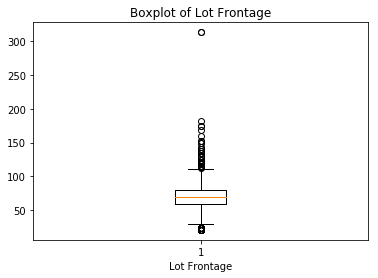

In [196]:
plt.title("Boxplot of Lot Frontage")
plt.xlabel("Lot Frontage")
plt.boxplot(data.LotFrontage[data.LotFrontage.notnull()]);

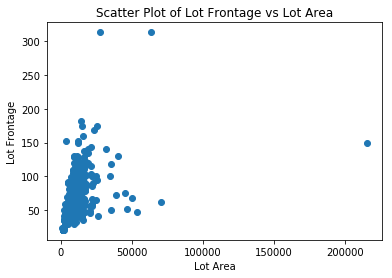

In [197]:
plt.title("Scatter Plot of Lot Frontage vs Lot Area")
plt.scatter(data["LotArea"],data["LotFrontage"])
plt.xlabel("Lot Area")
plt.ylabel("Lot Frontage")
plt.show()

In [198]:
data.drop(data[data.LotFrontage>300].index,inplace=True)
data.drop(data[data.LotArea>100000].index,inplace=True)

**Since the ratio of Lot Frontrage and Lot Area have a mean and median very close to each other. For the missing values of Lot Frontage, I have filled it with by mutliplying the median of the ratio to the Lot Area.**

In [199]:
print("Median of Lot Frontage by Lot Area:",np.median(data[data.LotFrontage.notnull()].LotFrontage/data[data.LotFrontage.notnull()].LotArea))
print("Mean of Lot Frontage by Lot Area:",np.mean(data[data.LotFrontage.notnull()].LotFrontage/data[data.LotFrontage.notnull()].LotArea))

Median of Lot Frontage by Lot Area: 0.0077147024921648995
Mean of Lot Frontage by Lot Area: 0.00790737330083729


In [200]:
impute_median=np.median(data[data.LotFrontage.notnull()].LotFrontage/data[data.LotFrontage.notnull()].LotArea)
data.loc[data[data.LotFrontage.isnull()].index,"LotFrontage"]=data[data.LotFrontage.isnull()].LotArea*impute_median

**Below, for the things which is not present in the house I have used the None or zero value.** 

In [201]:
data.MasVnrType.fillna("None",inplace=True)
data.MasVnrArea.fillna(0,inplace=True)
data.BsmtQual.fillna("None",inplace=True)
data.BsmtCond.fillna("None",inplace=True)
data.BsmtExposure.fillna("None",inplace=True)
data.BsmtFinType1.fillna("None",inplace=True)
data.BsmtFinType2.fillna("None",inplace=True)
data.FireplaceQu.fillna("None",inplace=True)
data.GarageFinish.fillna("None",inplace=True)
data.GarageQual.fillna("None",inplace=True)
data.GarageCond.fillna("None",inplace=True)
data.GarageType.fillna("None",inplace=True)

In [202]:
# Used the mode since almost all the houses have that type of Electrical  wiring
data.Electrical.fillna(data.Electrical.mode,inplace=True)

In [203]:
# Used 2010 since it is the max value and further processing will help to indicate no garage
data.GarageYrBlt.fillna(2010,inplace=True)

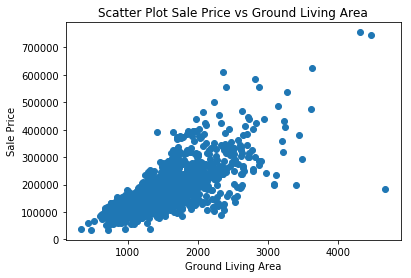

In [204]:
plt.title("Scatter Plot Sale Price vs Ground Living Area")
plt.scatter(y=data["SalePrice"],x=data["GrLivArea"])
plt.ylabel("Sale Price")
plt.xlabel("Ground Living Area")
plt.show()

In [205]:
# Dropped the outlier as it does not even follow the distribution
data.drop(index=523,inplace=True)

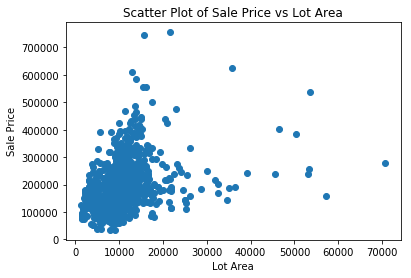

In [206]:
plt.title("Scatter Plot of Sale Price vs Lot Area")
plt.scatter(data["LotArea"],data["SalePrice"])
plt.ylabel("Sale Price")
plt.xlabel("Lot Area")
plt.show()

In [207]:
# Clip the Lot Area as we can see that it has outliers which do not follow the distribution as well
data.LotArea=np.clip(data.LotArea,a_max=30000,a_min=0)

In [208]:
# Dropped garage cars since it almost has the same meaning as garage area
# number of cars in garage depends on its area
data.drop("GarageCars",inplace=True,axis=1)

In [209]:
# Adding a new column Total area as it can be vary helpful in deciding the price 
data["TotalSF"]=data["TotalBsmtSF"]+data["2ndFlrSF"]+data["1stFlrSF"]

In [210]:
# To get it in number of years we subtract from maximum value
data.YearRemodAdd=2010-data.YearRemodAdd
data.YearBuilt=2010-data.YearBuilt

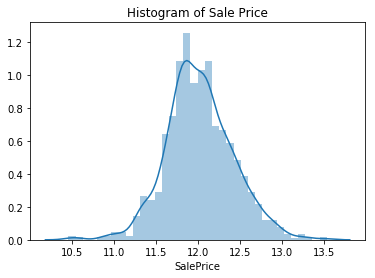

In [211]:
plt.title("Histogram of Sale Price")
sns.distplot(np.log(data.SalePrice));

In [212]:
# We are required to do the log transformation according to the loss function provided
# But apart from that we can see log transformation makes the target variable normal so it
# can help to imrove our model
data["SalePrice"]=np.log(data.SalePrice)

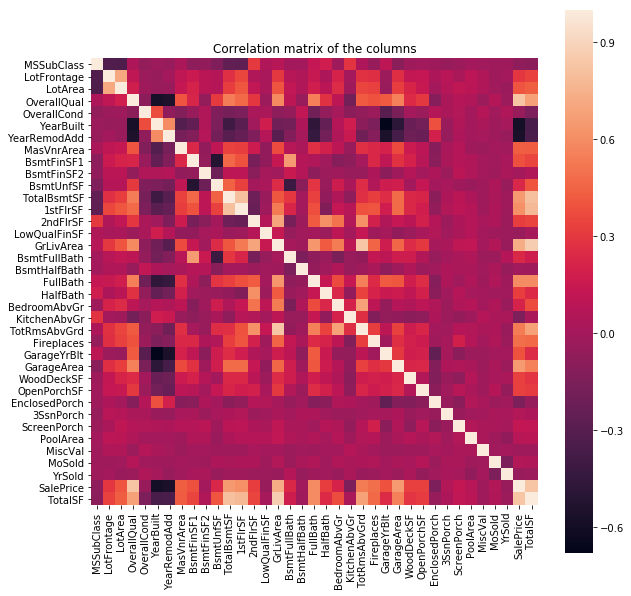

In [213]:
plt.figure(figsize=(10,10))
plt.title("Correlation matrix of the columns")
corr_mat=data.corr()
sns.heatmap(corr_mat,square=True)
plt.show()

**Below we center the continuous classes as required to improve prediction of the regression models and also for PCA in the next section. We also convert the categorical class into dummies.**

In [214]:
cat_class=[]
for i in data.columns:
    if data[i].dtype=="object":
        cat_class.append(i)
cat_class.extend(['MSSubClass','OverallQual', 'OverallCond'])

In [215]:
cont_class=[i for i in data.columns if ((i not in cat_class) & (i!="SalePrice"))]

In [216]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
data[cont_class]=scaler.fit_transform(data[cont_class])

D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [217]:
data.reset_index(inplace=True,drop=True)

In [218]:
data=data.join(pd.get_dummies(data[cat_class].astype("str"),drop_first=True))

In [219]:
data.drop(cat_class,inplace=True,axis=1)

In [220]:
data_pca=data.copy()

**Dealing with the high dimensionality was the biggest problem in the dataset. We have used two methods to deal with this problem:** 
<vr>1) Using the feature importance from models
<vr>2) Using PCA

## Using feature importance

**Two models have been used to remove features so that we reduce the dimensionality of the data. Using the feature importance of GBT and Lasso Regression we have extracted the important features. 
<br>GBT uses information gain to get the importance of the variable. 
<br>Lasso Regression uses L1 regularisation to remove features that are not useful for prediction.
<br>
<br>After getting the 200 least importaant varibales from both the models, we have extracted a set of 171 features that are common to both. This way we have dealt with unimportant features**

In [221]:
gbm=GradientBoostingRegressor(random_state=42)

In [222]:
gbm.fit(data[data.columns[data.columns!="SalePrice"]],data.SalePrice)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [223]:
gbm_feature_drop=[i[0] for i in sorted(zip(data.columns[data.columns!="SalePrice"],gbm.feature_importances_),key=lambda t:t[1])[:200]]

In [224]:
from sklearn.linear_model import Lasso

In [225]:
lasso=Lasso(alpha=0.002,random_state=42)

In [226]:
lasso.fit(data[data.columns[data.columns!="SalePrice"]],data.SalePrice)

Lasso(alpha=0.002, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)

In [227]:
lasso_feature_drop=[i[0] for i in sorted(zip(data.columns[data.columns!="SalePrice"],abs(lasso.coef_)),key=lambda t:t[1])[:200]]

In [228]:
data.drop(list(set(lasso_feature_drop).intersection(gbm_feature_drop)),axis=1,inplace=True)

In [229]:
from sklearn.model_selection import train_test_split

In [230]:
X_train,X_test,y_train,y_test=train_test_split(data[data.columns[data.columns!="SalePrice"]],data.SalePrice,random_state=42,test_size=0.2)

# Model

Metrics for tuning: Root mean squared error is the metrics for evaluating the performance of our model. But due to the unavailability of that metrics in scoring function of grid search, we maximize neg mean squared error in order to get the best model.

Cross Validation: 10 folds have been used for tuning the model to get a good generalized model and use as much as possible data for training the model. 

Grid Search: A simple grid search will try all combination for getting the hyperparameters which have the best average score on the all the testing folds.

Models:
<br>1) Linear regression model because they are simple models and have been known to perform well on regression tasks. As the data contains lot of features needs that to be eliminated, instead of using simple linear regression I have tried different variants of linear regression.
<br>2) GBM is used because it is known to perform well on mostly all of the task. Also, we can tune it so that it does not overfit due to the high dimensionality of the data.

### Lasso Regression

**Lasso regression is a modification of the linear regression model. The Lasso regression uses L1 regularisation in order to penalize the large co-efficients. As the alpha becomes small, the values constrain the model more and thus more features have  their co-efficients as 0.** 

In [231]:
lasso=Lasso(random_state=42)

In [232]:
param_grid_lasso={"alpha":[0,0.0001,0.001,0.01,0.1,1]}

In [233]:
grid_search_lasso=GridSearchCV(estimator=lasso,n_jobs=-1,param_grid=param_grid_lasso,scoring="neg_mean_squared_error",cv=10)

In [234]:
grid_search_lasso.fit(X_train,y_train)

D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [235]:
grid_search_lasso.best_params_

{'alpha': 0.0001}

In [236]:
np.sqrt(mean_squared_error(y_test,y_pred=grid_search_lasso.predict(X_test)))

0.11610868099601006

In [237]:
sorted(zip(data.columns[data.columns!="SalePrice"],abs(grid_search_lasso.best_estimator_.coef_)),key=lambda t:t[1])[-10:]

[('Exterior1st_BrkComm', 0.11471223787426377),
 ('SaleCondition_Partial', 0.11645188281087215),
 ('MSSubClass_160', 0.12177477906449022),
 ('OverallQual_8', 0.12353430879628083),
 ('OverallCond_7', 0.14166390435694512),
 ('OverallCond_8', 0.16334931352252624),
 ('OverallCond_9', 0.19521879426938055),
 ('OverallQual_2', 0.21438198471454503),
 ('OverallQual_9', 0.23655949363104975),
 ('OverallQual_10', 0.253453265722175)]

**As we can see from the co-efficients, that the overall condition and quality play a big role in deciding the price of the house.**

### Ridge Regression

**The Ridge regression is another variant of linear regression which uses L2 penalty. Unlike lasso it does not make the co-efficients 0 in order to eliminate them. It penalizes them to make it smaller so that the less important features have less impact on the output. The higher the aplha value more penalty is applied.**

In [49]:
ridge=Ridge(random_state=42)

In [50]:
param_grid_ridge={"alpha":[0,0.0001,0.001,0.01,0.1,1]}

In [51]:
grid_search_ridge=GridSearchCV(estimator=ridge,n_jobs=-1,param_grid=param_grid_ridge,scoring="neg_mean_squared_error",cv=10)

In [52]:
grid_search_ridge.fit(X_train,y_train)

D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [53]:
grid_search_ridge.best_params_

{'alpha': 1}

In [54]:
np.sqrt(mean_squared_error(y_test,y_pred=grid_search_ridge.predict(X_test)))

0.11593620468742287

In [55]:
sorted(zip(data.columns[data.columns!="SalePrice"],abs(grid_search_ridge.best_estimator_.coef_)),key=lambda t:t[1])[-10:]

[('Neighborhood_StoneBr', 0.1135203232805559),
 ('OverallCond_7', 0.11380805969351382),
 ('Exterior1st_BrkComm', 0.12133159501268401),
 ('MSSubClass_160', 0.12208988091638648),
 ('OverallCond_3', 0.1341815617883351),
 ('OverallCond_8', 0.13421727061326663),
 ('OverallCond_9', 0.16387433194573514),
 ('OverallQual_2', 0.1873837973413668),
 ('OverallQual_9', 0.21701032384286878),
 ('OverallQual_10', 0.22362125550876003)]

**We get similar results for ridge regression that we got for lasso regression. Here also overall quality and overall condition play a big role in deciding the price.**

### Elastic Net

**Elastic Net is a combination of L1 and L2. The ratio of L1 and L2 penalty to be applied is decided by the L1 ratio and they sum to 1. If the l1 rato is 1 than our model is using only L1 regularisation and no L2.**

In [56]:
elastic=ElasticNet(random_state=42)

In [57]:
param_grid_elastic={"alpha":[0,0.0001,0.001,0.01,0.1,1],"l1_ratio":[i/10 for i in range(0,11)]}

In [58]:
grid_search_elastic=GridSearchCV(estimator=elastic,n_jobs=-1,param_grid=param_grid_elastic,scoring="neg_mean_squared_error",cv=10)

In [59]:
grid_search_elastic.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=42, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [60]:
grid_search_elastic.best_params_

{'alpha': 0.001, 'l1_ratio': 0.4}

In [61]:
np.sqrt(mean_squared_error(y_test,y_pred=grid_search_elastic.predict(X_test)))

0.11712626743632976

In [62]:
sorted(zip(data.columns[data.columns!="SalePrice"],abs(grid_search_elastic.best_estimator_.coef_)),key=lambda t:t[1])[-10:]

[('OverallQual_8', 0.08341834483349186),
 ('OverallCond_7', 0.08348095023247713),
 ('Neighborhood_StoneBr', 0.08367751069372205),
 ('OverallQual_2', 0.08755459703142127),
 ('Neighborhood_Crawfor', 0.09379794056277466),
 ('OverallCond_8', 0.09769550075158923),
 ('OverallCond_9', 0.11683459622340195),
 ('OverallCond_3', 0.15517005029227185),
 ('OverallQual_10', 0.16617567794780935),
 ('OverallQual_9', 0.17841489514586073)]

**Here also we get the same results from above.**

### Gradient Boosting

Gradient Boosting are build using number of trees just like random forest but here we keep on improving the individual base learner by giving more weights to the points where the previous learner made an error.

**Model Tuning:** 

**n_estimators:** The important tuning parameter of the Random Forest is the number of trees to be used for predicting the result. 
<br>**max_features:** The max_features is the number of features that will be used for making a single tree. For eg using "sqrt", the tree uses the square root of the number of total features in the data. Using auto is the same as making use of sqrt. The other values can be specifying the int(number of features to be used less than the total features), log, and proportion of the features to be used.
<br>**min_samples_leaf:** The minimum number of samples that should be there in leaf node. If the number is less then the leaf node is pruned.
<br>**min_samples_split:** The number of samples that should be present in the node for it to be split further.
<br>**sub_sample:** The proportion of sample to be used for training individual base learner.
<br>**learning_rate:** The learning rate corresponds to how quickly the error is corrected from each tree to the next and is a simple multiplier. 

In [63]:
gbm=GradientBoostingRegressor(random_state=42)

In [64]:
param_grid_gbm={"n_estimators":[50,80,100,150,200,500],"learning_rate":[0.01,0.1,.5],
               "max_features":["sqrt","log2"],"subsample":(.75,0.8,0.85),"max_depth":(4,5,6,8,16,20),"min_samples_split":(12,16,20)}

In [65]:
grid_search_gbm=GridSearchCV(estimator=gbm,n_jobs=-1,param_grid=param_grid_gbm,scoring="neg_mean_squared_error",cv=10,verbose=1)

In [66]:
grid_search_gbm.fit(X_train,y_train)

Fitting 10 folds for each of 1944 candidates, totalling 19440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 966 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 1612 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3483 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 4234 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 5025 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 5875 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 7109 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 9107 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 10824 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 12074 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 13948 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 16848 tasks   

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': ['sqrt', 'log2'], 'learning_rate': [0.01, 0.1, 0.5], 'max_depth': (4, 5, 6, 8, 16, 20), 'subsample': (0.75, 0.8, 0.85), 'n_estimators': [50, 80, 100, 150, 200, 500], 'min_samples_split': (12, 16, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [67]:
grid_search_gbm.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'max_features': 'log2',
 'min_samples_split': 12,
 'n_estimators': 200,
 'subsample': 0.85}

In [68]:
np.sqrt(mean_squared_error(y_test,y_pred=grid_search_gbm.predict(X_test)))

0.12148306021875616

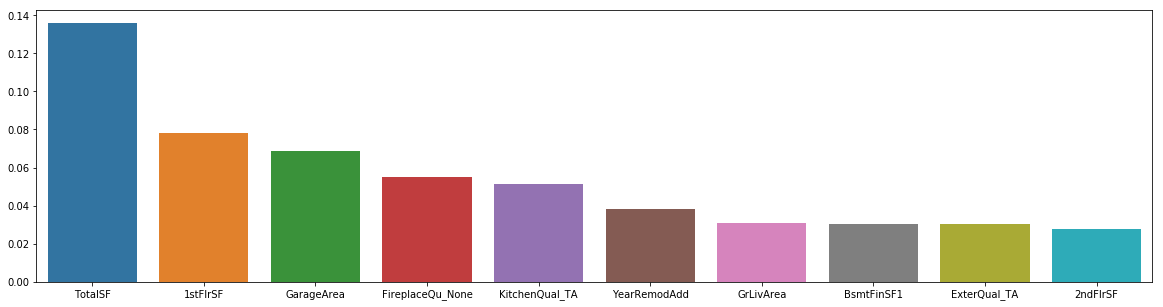

In [69]:
plt.figure(figsize=(20,5))
feature_importance_gbm=OrderedDict(sorted(zip(X_train.columns,grid_search_gbm.best_estimator_.feature_importances_),reverse=True,key=lambda x:x[1]))
sns.barplot(list(feature_importance_gbm.keys())[:10],list(feature_importance_gbm.values())[:10]);

**The top 10 features that we have got here are completely different from our regression models.**

## Principal Component Analysis

**Principal Component Analysis technique is a dimensional reduction technique. We can use this technique to select the top components which can help us to explain the maximum variance in our data set. As from our graph we can see that the first 100 components can help us to explain almost all the variance in the data i.e around 97%.**

In [70]:
X_train,X_test,y_train,y_test=train_test_split(data_pca[data_pca.columns[data_pca.columns!="SalePrice"]],data_pca.SalePrice,random_state=42,test_size=0.2)

In [71]:
from sklearn.decomposition import PCA

In [72]:
pca=PCA(random_state=42)

In [73]:
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)

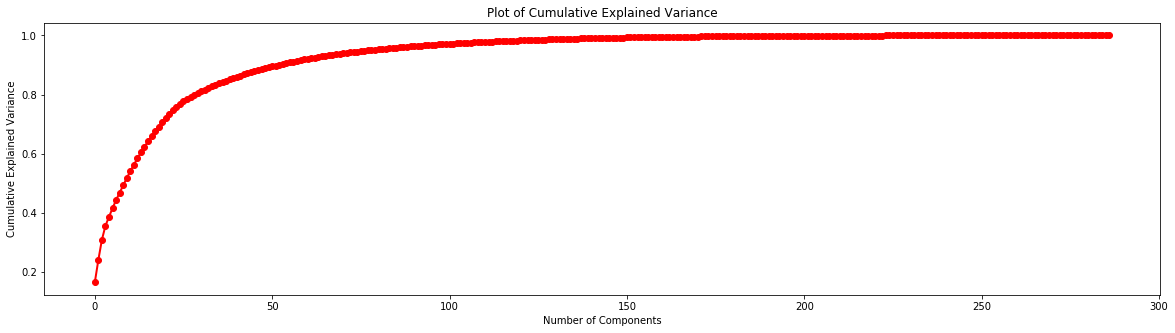

In [74]:
plt.figure(figsize=(20,5))
plt.title("Plot of Cumulative Explained Variance")
plt.ylabel("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.plot(np.arange(287),np.cumsum(pca.explained_variance_ratio_),"ro-", linewidth=2);

In [75]:
X_train=X_train[:,:100]
X_test=X_test[:,:100]

In [76]:
# The cumulative explained variance of first 100 components
np.cumsum(pca.explained_variance_ratio_)[100]

0.9714878686306491

## Lasso

In [77]:
lasso=Lasso(random_state=42)

In [78]:
param_grid_lasso={"alpha":[0,0.0001,0.001,0.01,0.1,1]}

In [79]:
grid_search_lasso=GridSearchCV(estimator=lasso,n_jobs=-1,param_grid=param_grid_lasso,scoring="neg_mean_squared_error",cv=10)

In [80]:
grid_search_lasso.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [81]:
grid_search_lasso.best_params_

{'alpha': 0.0001}

In [82]:
np.sqrt(mean_squared_error(y_test,y_pred=grid_search_lasso.predict(X_test)))

0.12678431647684965

### Ridge Regression

In [83]:
ridge=Ridge(random_state=42)

In [84]:
param_grid_ridge={"alpha":[0,0.0001,0.001,0.01,0.1,1]}

In [85]:
grid_search_ridge=GridSearchCV(estimator=ridge,n_jobs=-1,param_grid=param_grid_ridge,scoring="neg_mean_squared_error",cv=10)

In [86]:
grid_search_ridge.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

### XGBoost

In [70]:
xgb=XGBRegressor(seed=27)

In [71]:
param_grid_xgb={'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],"n_estimators":[50,80,100,150,200,500],
               "max_depth":(4,5,6,8,16,20),'gamma':[i/10.0 for i in range(0,5)]}

In [72]:
grid_search_xgb=GridSearchCV(estimator=xgb,n_jobs=-1,param_grid=param_grid_xgb,scoring="neg_mean_squared_error",cv=10,verbose=1)

In [73]:
grid_search_xgb.fit(X_train,y_train)

Fitting 10 folds for each of 900 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 44.8min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 49.8min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 57.5min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': (4, 5, 6, 8, 16, 20), 'n_estimators': [50, 80, 100, 150, 200, 500], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [74]:
grid_search_xgb.best_params_

{'gamma': 0.0, 'max_depth': 4, 'n_estimators': 500, 'reg_alpha': 0.01}

In [75]:
np.sqrt(mean_squared_error(y_test,y_pred=grid_search_xgb.predict(X_test)))

0.12405497418823616

In [87]:
grid_search_ridge.best_params_

{'alpha': 1}

In [88]:
np.sqrt(mean_squared_error(y_test,y_pred=grid_search_ridge.predict(X_test)))

0.12661338741697278

### Elastic Net

In [89]:
elastic=ElasticNet(random_state=42)

In [90]:
param_grid_elastic={"alpha":[0,0.0001,0.001,0.01,0.1,1],"l1_ratio":[i/10 for i in range(0,11)]}

In [91]:
grid_search_elastic=GridSearchCV(estimator=elastic,n_jobs=-1,param_grid=param_grid_elastic,scoring="neg_mean_squared_error",cv=10)

In [92]:
grid_search_elastic.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=42, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [93]:
grid_search_elastic.best_params_

{'alpha': 0.001, 'l1_ratio': 0.5}

In [94]:
np.sqrt(mean_squared_error(y_test,y_pred=grid_search_elastic.predict(X_test)))

0.1274855789927612

### Gradient Boosting

In [95]:
gbm=GradientBoostingRegressor(random_state=42)

In [96]:
param_grid_gbm={"n_estimators":[50,80,100,150,200,500],"learning_rate":[0.01,0.1,.5],
               "max_features":["sqrt","log2"],"subsample":(.75,0.8,0.85),"max_depth":(4,5,6,8,16,20),"min_samples_split":(12,16,2024)}

In [97]:
grid_search_gbm=GridSearchCV(estimator=gbm,n_jobs=-1,param_grid=param_grid_gbm,scoring="neg_mean_squared_error",cv=10,verbose=1)

In [98]:
grid_search_gbm.fit(X_train,y_train)

Fitting 10 folds for each of 1944 candidates, totalling 19440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 436 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 1006 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 1788 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2633 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3577 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4647 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 6092 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 7895 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 9993 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 12001 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 14388 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 17974 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 19440 out of 19440 | elapsed: 19.1min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': ['sqrt', 'log2'], 'learning_rate': [0.01, 0.1, 0.5], 'max_depth': (4, 5, 6, 8, 16, 20), 'subsample': (0.75, 0.8, 0.85), 'n_estimators': [50, 80, 100, 150, 200, 500], 'min_samples_split': (12, 16, 2024)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [99]:
grid_search_gbm.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_split': 16,
 'n_estimators': 500,
 'subsample': 0.85}

In [100]:
np.sqrt(mean_squared_error(y_test,y_pred=grid_search_gbm.predict(X_test)))

0.17154012590514373

**Conclusion and Interpretation: From the results, we can see that complex functions are not always the best. We can make use of simpler models to get better results for simple problems. Feature elimination is an important step when dealing with high dimensionality. Using PCA and feature importance both gave us similar results and we can infer that using unimportant features can negatively effect our model's predictive capability. Our models used heavy penalization because our model contained lot of features, and it was important to eliminate these features. From our regression models the top features we got was Overall Quality and Overall Condition. But, our top 10 features for GBM were completely different. The best model that we got were Lasso and Ridge which used feature importance to eliminate features.** 